In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *
import sys
sys.path.append("../")
from utils.fehler_gauss import fehler_gauss
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

## Beugung Spalt

In [18]:
pos_spalt = 27e-3

u_pos_objekte = 3e-3 # 3mm Unsicherheit für alle Objekte auf der optischen Bank

pos_laser = 1.5e-2
u_pos_laser = 5e-3

d_schirm_papier = 0.6e-2

u_ablese = 0.5e-3 # halber Millimeter Unsicherheit beim Ablesen
u_messschieber = 0.05e-3 # 0.05mm Unsicherheit beim Messschieber nach Herstellerangabe

lambda_laser = 532e-9
u_lambda_laser = 1e-9

beugung_spalt = pd.read_excel("BUB.xlsx", sheet_name="LaserBeugungSpalt")
beugung_spalt[[i for i in range(1, 6)]] *= 1e-2 # Abstaende Minima in cm
beugung_spalt["Position Schirm"] *= 1e-2 # Position Schirm in cm
beugung_spalt

,Position Schirm,1,2,3,4,5
0,1.97,0.0159,0.0314,0.0469,0.06075,0.0752
1,1.30,0.0100,0.0185,0.0255,0.03500,0.0450
2,0.77,0.0055,0.0105,0.0145,0.01900,0.0235


$$\tan \alpha = \frac{s}{l}$$

Die Werte im DataFrame sind die Abstände zwischen zwei Minima gleicher Ordnung, also $2 s$.

$l$ ist der Abstand zwischen Spalt und Schirm

In [19]:
s = beugung_spalt[[i for i in range(1, 6)]] / 2
u_s = np.sqrt(u_messschieber**2 + u_ablese**2 + 1e-3**2)

l = beugung_spalt["Position Schirm"] + d_schirm_papier - pos_spalt
u_l = np.sqrt(u_pos_objekte**2 + u_ablese**2 + u_messschieber**2)

s

,1,2,3,4,5
0,0.00795,0.01570,0.02345,0.030375,0.03760
1,0.00500,0.00925,0.01275,0.017500,0.02250
2,0.00275,0.00525,0.00725,0.009500,0.01175


In [20]:
u_s * 1e3

np.float64(1.1191514642799696)

In [21]:
# s durch l mit Fehlern berechnen
s_symbol, l_symbol = symbols("s l")
s_durch_l_formula = s_symbol / l_symbol

s_durch_l, u_s_durch_l = fehler_gauss(
    s_durch_l_formula,
    [s_symbol, l_symbol],
    [s.values, l.values.repeat(5).reshape(3, 5)],
    [u_s, u_l]
)
s_durch_l

array([[0.00407901, 0.00805541, 0.01203181, 0.01558492, 0.01929194],
       [0.0039093 , 0.00723221, 0.00996873, 0.01368256, 0.01759187],
       [0.00367156, 0.00700935, 0.00967957, 0.01268358, 0.01568758]])

Minima: $n \lambda = d \sin\alpha \approx d \frac{s}{l} \implies n \frac{\lambda}{d} = \frac{s}{l}$
Steigung aus linearer Regression: $m = \frac{\lambda}{d} \implies d = \frac{\lambda}{m}$

In [22]:
# s durch l in DataFrame
s_durch_l = pd.DataFrame(s_durch_l, columns=[i for i in range(1, 6)])
s_durch_l[[f"u_{i}" for i in range(1, 6)]] = u_s_durch_l

# exakt berechnete alphas
alphas = np.arctan(s / l.values.repeat(5, axis=0).reshape((3, 5)))

# durchschnittliche relative Abweichungen der Kleinwinkelnäherung
rel_abweichungen = ((alphas / s_durch_l) - 1).abs()[[i for i in range(1, 6)]].mean()
rel_abweichungen.mean() * 100 # durchschnittliche relative Abweichung in Prozent

np.float64(0.004595579860963522)

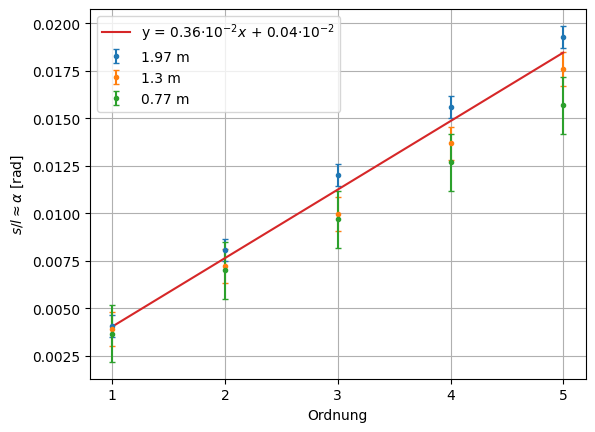

In [23]:
alphas_vals = s_durch_l[[i for i in range(1, 6)]]
alphas_errs = s_durch_l[[f"u_{i}" for i in range(1, 6)]]

# Regression s/l gegen Ordnung
def linear(x, m, b):
    return m * x + b

n = alphas_vals.columns.repeat(3).values.reshape((5, 3)).T.flatten()
popt, pcov = curve_fit(linear, n, alphas_vals.values.flatten(), sigma=alphas_errs.values.flatten())

X = np.linspace(n.min(), n.max(), 100)
Y = linear(X, *popt)

for i in range(0, 3):
    plt.errorbar(
        x=alphas_vals.columns,
        y=alphas_vals.iloc[i],
        fmt=".",
        capsize=2,
        yerr=alphas_errs.iloc[i],
        label=f"{beugung_spalt.iloc[i]["Position Schirm"]} m",
    )
fit_label = "y = " + \
    str(np.round(popt[0] * 100, 2)) + r"$\cdot 10^{-2} x$ + " + str(np.round(popt[1] * 100, 2)) + r"$\cdot 10^{-2}$"
plt.plot(X, Y, label=fit_label)
plt.grid(True)
plt.legend()
plt.xlabel("Ordnung")
plt.ylabel(r"$s/l \approx \alpha$ [rad]")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig("beugung_spalt.svg")

In [24]:
print("Steigung:", popt[0], "+-", np.sqrt(pcov[0, 0]))

Steigung: 0.0036052982465836323 +- 0.00017078212210612333


In [25]:
lambda_symbol, m_symbol = symbols("lambda m")
d_formula = lambda_symbol / m_symbol

d_val, u_d = fehler_gauss(
    d_formula,
    [lambda_symbol, m_symbol],
    [lambda_laser, popt[0]],
    [u_lambda_laser, np.sqrt(pcov[0, 0])]
)
print("Spaltbreite:", d_val * 1e6, "+-", u_d * 1e6, "µm")

Spaltbreite: 147.56060764296583 +- 6.995411999582303 µm


## Beugung am Gitter

In [26]:
pos_schirm = np.array([63.5, 45.4, 34.1])
u_pos_schirm = 0.5e-3

pos_gitter = 6.7e-3
u_pos_gitter = 0.5e-3

dfs = {
    i: pd.read_excel("BUB.xlsx", sheet_name=f"Beugungsgitter{i}") for i in range(1, 4)
}
beugung_gitter = pd.concat(dfs)
beugung_gitter["Position Schirm"] = pos_schirm.repeat(5)
beugung_gitter *= 1e-2  # Abstaende Minima in cm
beugung_gitter

Blau  Gruen  Orange  Position Schirm
1 0  0.051  0.063   0.067            0.635
  1  0.102  0.128   0.135            0.635
  2  0.153  0.193   0.204            0.635
  3  0.179  0.259   0.273            0.635
  4    NaN  0.328   0.350            0.635
2 0  0.036  0.043   0.047            0.454
  1  0.074  0.088   0.093            0.454
  2  0.144  0.133   0.141            0.454
  3  0.178  0.179   0.191            0.454
  4  0.215  0.226   0.242            0.454
3 0  0.026  0.033   0.035            0.341
  1  0.051  0.064   0.067            0.341
  2  0.077  0.096   0.101            0.341
  3  0.105  0.128   0.137            0.341
  4  0.144  0.165   0.175            0.341

In [27]:
# s berechnen (Position Schirm - Position Gitter)
s_gitter = beugung_gitter[["Blau", "Gruen", "Orange"]] / 2
u_s_gitter = np.sqrt(u_messschieber**2 + u_ablese**2)
beugung_gitter[["s Blau", "s Gruen", "s Orange"]] = s_gitter

# l berechnen (Position Papier - Position Gitter)
l_gitter = beugung_gitter["Position Schirm"] + d_schirm_papier - pos_gitter
u_l_gitter = np.sqrt(u_ablese**2 + u_messschieber**2 + u_pos_objekte**2)
beugung_gitter["l"] = l_gitter

print("u_s_gitter:", u_s_gitter)
print("u_l_gitter:", u_l_gitter)

beugung_gitter

u_s_gitter: 0.0005024937810560445
u_l_gitter: 0.003041792234851026


Blau  Gruen  Orange  Position Schirm  s Blau  s Gruen  s Orange       l
1 0  0.051  0.063   0.067            0.635  0.0255   0.0315    0.0335  0.6343
  1  0.102  0.128   0.135            0.635  0.0510   0.0640    0.0675  0.6343
  2  0.153  0.193   0.204            0.635  0.0765   0.0965    0.1020  0.6343
  3  0.179  0.259   0.273            0.635  0.0895   0.1295    0.1365  0.6343
  4    NaN  0.328   0.350            0.635     NaN   0.1640    0.1750  0.6343
2 0  0.036  0.043   0.047            0.454  0.0180   0.0215    0.0235  0.4533
  1  0.074  0.088   0.093            0.454  0.0370   0.0440    0.0465  0.4533
  2  0.144  0.133   0.141            0.454  0.0720   0.0665    0.0705  0.4533
  3  0.178  0.179   0.191            0.454  0.0890   0.0895    0.0955  0.4533
  4  0.215  0.226   0.242            0.454  0.1075   0.1130    0.1210  0.4533
3 0  0.026  0.033   0.035            0.341  0.0130   0.0165    0.0175  0.3403
  1  0.051  0.064   0.067            0.341  0.0255   0.0320    0.0335  0.3403
  2  0.077  0.096   0.101            0.341  0.0385   0.0480    0.0505  0.3403
  3  0.105  0.128   0.137            0.341  0.0525   0.0640    0.0685  0.3403
  4  0.144  0.165   0.175            0.341  0.0720   0.0825    0.0875  0.3403

In [28]:
# zeigen, dass die Kleinwinkelnäherung zu ungenau ist
alphas_kwn = s_gitter / l_gitter.repeat(3).values.reshape((15, -1))
alphas_exact = np.arctan(s_gitter / l_gitter.repeat(3).values.reshape((15, -1)))
rel_abweichungen = (np.abs(alphas_exact - alphas_kwn) / alphas_exact).dropna()
rel_abweichungen.values.mean() * 100  # in Prozent, größer als vorher

np.float64(0.7668924055128794)

In [29]:
# Exakte Winkel auftragen
sin_formula = sin(atan(s_symbol / l_symbol))
sin_formula

s/(l*sqrt(1 + s**2/l**2))

In [30]:
sin_vals, u_sin_vals = fehler_gauss(
    sin_formula,
    [s_symbol, l_symbol],
    [s_gitter.values, l_gitter.values.repeat(3).reshape(15, -1)],
    [u_s_gitter, u_l_gitter]
)
sin_vals

array([[0.04016935, 0.04959992, 0.05274062],
       [0.08014495, 0.10038892, 0.10581904],
       [0.1197377 , 0.15040557, 0.15876751],
       [0.13971645, 0.20003567, 0.21038159],
       [       nan, 0.25032116, 0.26595822],
       [0.03967753, 0.0473767 , 0.05177252],
       [0.08135309, 0.0966119 , 0.10204557],
       [0.15686874, 0.14514837, 0.15367863],
       [0.1926597 , 0.19370156, 0.20615191],
       [0.23074985, 0.24188082, 0.25790143],
       [0.03817374, 0.04842973, 0.05135735],
       [0.07472438, 0.09362166, 0.09796899],
       [0.1124183 , 0.13966945, 0.14679095],
       [0.15247182, 0.18482904, 0.19733478],
       [0.20699563, 0.2356082 , 0.24902579]])

Maxima beim Beugungsgitter: $n \cdot \lambda = a \sin\alpha \implies \frac{\lambda}{a} n = \sin\alpha$

Steigung $m = \frac{\lambda}{a} \implies \lambda = m \cdot a$

In [31]:
a_symbol = symbols("a")

lambda_formula = m_symbol * a_symbol
lambda_formula

a*m

Gerade geht durch den Ursprung, Achsenabschnitt: -0.002473579842884148 +- 0.008736190091911535
416.4579600691976 +- 32.02303719243528 nm


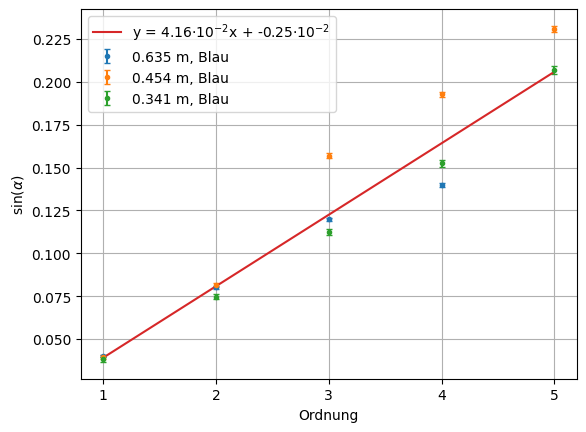

Gerade geht durch den Ursprung, Achsenabschnitt: -0.0001778047815664901 +- 0.002164915908163371
490.70281343244005 +- 7.590318394313022 nm


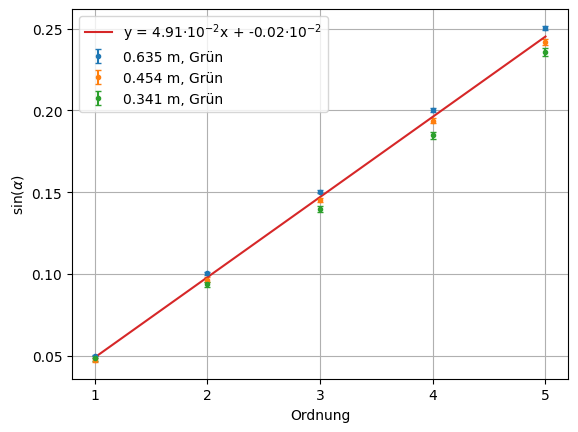

Gerade geht durch den Ursprung, Achsenabschnitt: -0.00010569225443441295 +- 0.002184863239962914
519.4188960584439 +- 7.736845684926938 nm


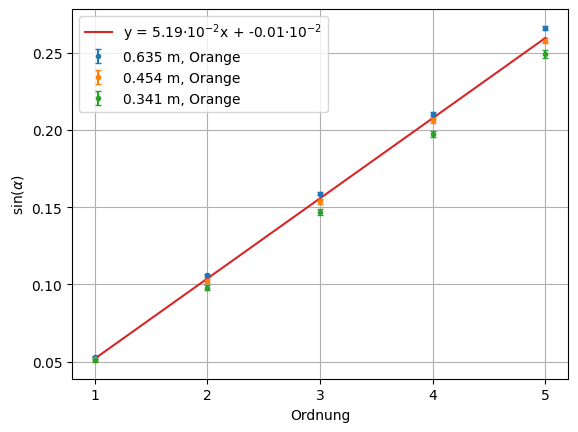

In [32]:
a = 10e-6
u_a = 0.2e-2 * a # 0.2% relative Unsicherheit

farben = ["Blau", "Grün", "Orange"]
for i, farbe in enumerate(farben):
    # Regression durchfuehren fuer jede Farbe
    n = np.tile(np.arange(1, 6), 3)
    no_nans = ~np.isnan(sin_vals[:, i]) # filter nans
    n = n[no_nans]
    sin_vals_no_nans = sin_vals[no_nans, i]
    u_sin_vals_no_nans = u_sin_vals[no_nans, i]
    popt, pcov = curve_fit(linear, n, sin_vals_no_nans, sigma=u_sin_vals_no_nans)
    X = np.linspace(n.min(), n.max(), 100)
    Y = linear(X, *popt)

    # checken, ob die Gerade durch den Ursprung geht
    achsenabschnitt = popt[1]
    u_achsenabschnitt = np.sqrt(pcov[1, 1])
    achsenabschnitt_max = achsenabschnitt + u_achsenabschnitt
    achsenabschnitt_min = achsenabschnitt - u_achsenabschnitt

    if achsenabschnitt_min <= 0 <= achsenabschnitt_max:
        print(f"Gerade geht durch den Ursprung, Achsenabschnitt: {achsenabschnitt} +- {u_achsenabschnitt}")

    # Wellenlaenge berechnen
    lambda_val, u_lambda = fehler_gauss(
        lambda_formula,
        [m_symbol, a_symbol],
        [popt[0], a],
        [np.sqrt(pcov[0, 0]), u_a]
    )
    print(lambda_val * 1e9, "+-", u_lambda * 1e9, "nm")

    # Plotten
    for j in range(3):
        plt.errorbar(
            x=np.arange(1, 6),
            y=sin_vals[j*5:((j+1)*5), i],
            fmt=".",
            capsize=2,
            yerr=u_sin_vals[j*5:((j+1)*5), i],
            label=f"{beugung_gitter.iloc[j*5]['Position Schirm']} m, {farbe}",
        )
    fit_label = f"y = {np.round(popt[0] * 100, 2)}" + r"$\cdot 10^{-2}$" + f"x + {np.round(popt[1] * 100, 2)}" + r"$\cdot 10^{-2}$"
    plt.plot(X, Y, label=fit_label)
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xlabel("Ordnung")
    plt.ylabel(r"$\sin(\alpha)$")
    plt.legend()
    plt.show()

![Literaturwerte](literaturwerte.png)

## Brechung im Prisma

Öffnungswinkel: $\varepsilon = \frac{\alpha}{2}$

In [18]:
u_winkel_deg = 0.1

# Oeffnungswinkel
alpha = 125.1 - 5.3
epsilon = alpha/2
u_epsilon = np.sqrt(2 * u_winkel_deg**2)
print("Oeffnungswinkel:", epsilon, "+-", u_epsilon, "Grad")

Oeffnungswinkel: 59.9 +- 0.14142135623730953 Grad


In [19]:
# importieren der Messwerte
prisma_quecksilber = pd.read_excel("BUB.xlsx", sheet_name="PrismaQuecksilber")
prisma_energiesparlampe = pd.read_excel("BUB.xlsx", sheet_name="PrismaEnergiesparlampe")

# Wellenlaengen der Spektrallinien
prisma_quecksilber["lambda"] = [578.966, 435.8343, 546.0740]

for df in [prisma_quecksilber, prisma_energiesparlampe]:
    # delta_min berechnen
    df["delta_min"] = df["ohne"] - df["mit"]
    df["u_delta_min"] = np.sqrt(2 * u_winkel_deg**2)

    # Winkelangaben in rad umrechnen
    df["delta_min"] = np.deg2rad(df["delta_min"])
    df["u_delta_min"] = np.deg2rad(df["u_delta_min"])

In [20]:
delta_min_symbol, epsilon_symbol = symbols("delta_min epsilon")
n_formula = sin((delta_min_symbol + epsilon_symbol) / 2) / sin(epsilon_symbol / 2)
n_formula

sin(delta_min/2 + epsilon/2)/sin(epsilon/2)

In [21]:
# Brechungsindex berechnen
epsilon_rad = np.deg2rad(epsilon)
u_epsilon_rad = np.deg2rad(u_epsilon)

# fuer Quecksilber und die Energiesparlampe
for df in [prisma_quecksilber, prisma_energiesparlampe]:
    n_val, u_n = fehler_gauss(
        n_formula,
        [delta_min_symbol, epsilon_symbol],
        [df["delta_min"].values, epsilon_rad],
        [df["u_delta_min"].values, u_epsilon_rad]
    )
    df["n"] = n_val
    df["u_n"] = u_n

prisma_quecksilber_preview = prisma_quecksilber[["lambda", "n", "u_n"]]
prisma_quecksilber_preview["lambda"] = prisma_quecksilber_preview["lambda"].round(2)
ns = list(zip(prisma_quecksilber_preview["n"].values, prisma_quecksilber_preview["u_n"].values))
ns = [r"\SI{"+str(np.round(n, 3))+"+-"+str(np.round(u_n, 3))+r"}{}" for n, u_n in ns]
prisma_quecksilber_preview["n"] = ns
prisma_quecksilber_preview = prisma_quecksilber_preview.drop(columns="u_n")
prisma_quecksilber_preview

/tmp/ipykernel_4356/318762674.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prisma_quecksilber_preview["lambda"] = prisma_quecksilber_preview["lambda"].round(2)
/tmp/ipykernel_4356/318762674.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prisma_quecksilber_preview["n"] = ns


,lambda,n
0,578.97,\SI{1.624+-0.002}{}
1,435.83,\SI{1.645+-0.003}{}
2,546.07,\SI{1.625+-0.002}{}


In [22]:
prisma_quecksilber["Farbe"]

0    Orange
1      Blau
2     Gruen
Name: Farbe, dtype: object

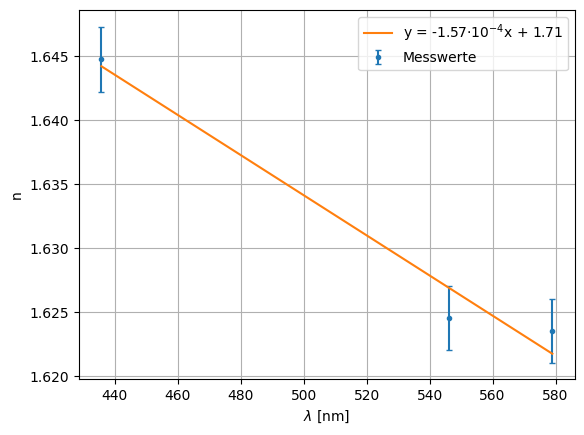

In [24]:
# Brechungsindex gegen Wellenlaenge auftragen
popt, pcov = curve_fit(linear, prisma_quecksilber["lambda"], prisma_quecksilber["n"], sigma=prisma_quecksilber["u_n"])
X = np.linspace(prisma_quecksilber["lambda"].min(), prisma_quecksilber["lambda"].max(), 100)
Y = linear(X, *popt)

plt.errorbar(
    x=prisma_quecksilber["lambda"],
    y=prisma_quecksilber["n"],
    fmt=".",
    capsize=2,
    yerr=prisma_quecksilber["u_n"],
    label="Messwerte",
)
fit_label = f"y = {np.round(popt[0] * 1e4, 2)}" + r"$\cdot 10^{-4}$" + f"x + {np.round(popt[1], 2)}"
plt.plot(X, Y, label=fit_label)
plt.grid(True)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("n")
plt.legend()
plt.savefig("brechungsindex.svg")

In [25]:
# Wellenlaengen der Spektrallinien aus der Energiesparlampe bestimmen
def wellenlaenge(brechungsindex):
    return (1/popt[0]) * brechungsindex - (popt[1]/popt[0])

prisma_energiesparlampe["lambda"] = wellenlaenge(prisma_energiesparlampe["n"])

prisma_energiesparlampe["n"] = prisma_energiesparlampe["n"].round(3)
prisma_energiesparlampe["lambda"] = prisma_energiesparlampe["lambda"].round(2)

prisma_energiesparlampe.sort_values(by="lambda")[["Farbe", "n", "lambda"]]

,Farbe,n,lambda
1,Blau,1.646,425.93
2,Gruen,1.625,560.98
0,Orange,1.623,574.03
3,Rot,1.618,600.21
